In [137]:
using Gadfly
using HDF5
using DataFrames

include("../pseudogp_student.jl"); # load in inference & plotting methods;

In [138]:
X = h5read("../data/embeddings.h5", "monocle/embedding")
t_gt = h5read("../data/embeddings.h5", "monocle/pseudotime");

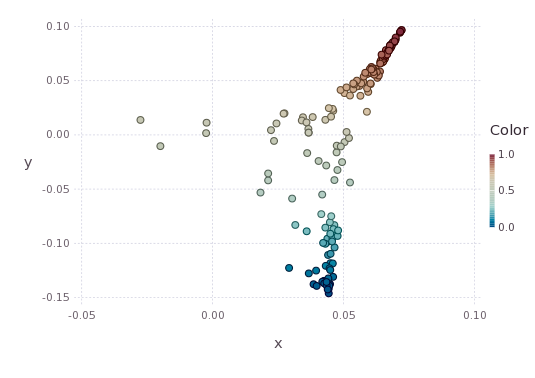

In [139]:
plot(x = X[:,1], y = X[:,2], colour = t_gt)

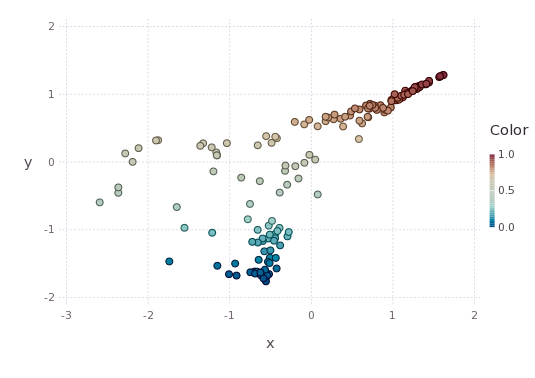

In [140]:
# remove cells less than 0 on x
to_keep = X[:,1] .> 0
X = X[to_keep,:]
t_gt = t_gt[to_keep]

x = X[:,1] ; y = X[:,2]
xs = (x - mean(x)) / sqrt(var(x))
ys = (y - mean(y)) / sqrt(var(y))
plot(x = xs, y = ys, color = t_gt)

In [141]:

#plot(x = X[:,1], y = X[:,2], colour = t_gt)
X_old = X
X = [xs ys];
size(X)

(155,2)

### Inference

In [142]:
include("../pseudogp_student.jl");
srand(123)

n = size(X)[1]

n_iter = int(1e6)
burn = n_iter / 2

thin = int(n_iter / 1000)

# pseudotime parameters
eps = 1e-6
t =  rand(Uniform(.5 - eps, .5 + eps), n) # t_gt #  
tvar = 6.5e-3

# GP function
guess_at_variance = 5e-2
tau = fill(1 / guess_at_variance, size(X))
tauvar = [1, 1] * 2e-1

# kernel parameters
lambda_init = [10, 10]
sigma_init = [1 / guess_at_variance, 1 / guess_at_variance]

lvar = [1, 1] * 1e-1
svar = tauvar # [1, 1] * 1

r = 1e-3 # repulsion parameter

return_burn = true # should the burn period be returned in the traces?
cell_swap_probability = 0 # randomly swap two cells at each stage?

gamma = 50000.0

mh1 = pseudogp_student(X, n_iter, burn, thin, tau, tauvar, t, tvar, lambda_init, lvar, 
sigma_init, svar, r = r, gamma = gamma)

Dict{Any,Any} with 11 entries:
  "burn_acceptance_rate" => 0.151567
  "r"                    => 0.001
  "lambda_prior_chain"   => [-21.639956568820566,-21.63999870865029,-21.64002974…
  "tchain"               => [0.5000005368953504 0.5000008810300015 0.50000034791…
  "acceptance_rate"      => 0.151567
  "lambda_chain"         => [10.0 10.0…
  "sigma_chain"          => [20.0 20.0…
  "params"               => {"n_iter"=>1000000,"burn_thin"=>500,"burn"=>500000.0…
  "likelihood_chain"     => [-2908.571922780727,-420.4417315268853,-232.63024230…
  "tau_chain"            => [20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 20.0 2…
  "prior_chain"          => [-321.03415261182835,-34.25943766897348,-28.52335896…

In [31]:
## write traces to file for plotting with R
trace_file = "../data/lambda_traces.h5"

h5write(trace_file,  "tchain", mh1["tchain"])
h5write(trace_file, "lambda_chain", mh1["lambda_chain"])
h5write(trace_file, "sigma_chain", mh1["sigma_chain"])
h5write(trace_file, "n_iter",  n_iter,)
h5write(trace_file, "log_lik", mh1["loglik_chain"])
h5write(trace_file, "prior", mh1["prior_chain"])
h5write(trace_file, "lambda_prior", mh1["lambda_prior_chain"])
h5write(trace_file, "t_gt", t_gt)
h5write(trace_file, "X", X)
h5write(trace_file, "to_keep", int(to_keep))


h5write(trace_file, "tvar", tvar)
h5write(trace_file,  "lvar", lvar)
h5write(trace_file, "svar", svar)

In [36]:
#mh1["tau_chain"][:,1,:]

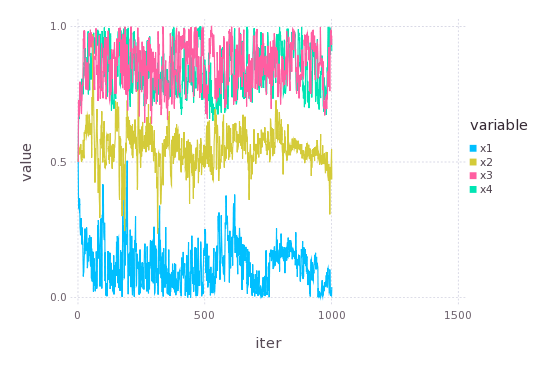

In [143]:
plot_pseudotime_trace(mh1)

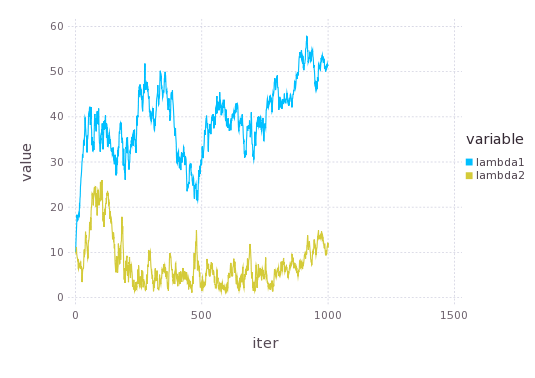

In [144]:
plot_kernel_parameter(mh1, "lambda")

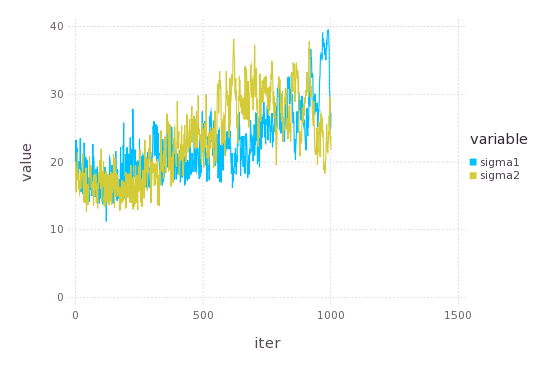

In [145]:
plot_kernel_parameter(mh1, "sigma")

1000000


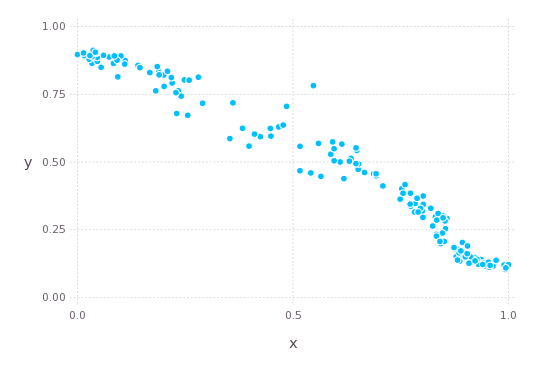

In [146]:
bt = mh1["params"]["burn_thin"]
println(mh1["params"]["n_iter"])
Gadfly.plot(x = vec(t_gt), y = vec(mean(mh1["tchain"][bt:end,:], 1)))

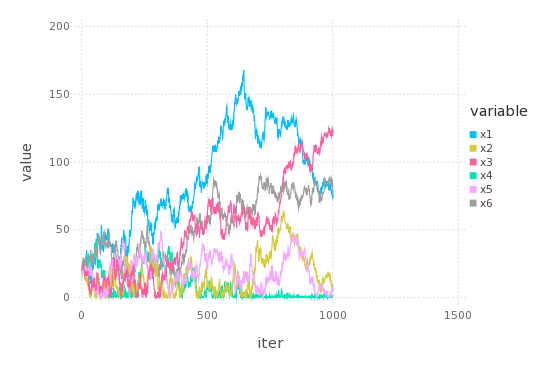

In [147]:
plot_tau(mh1)

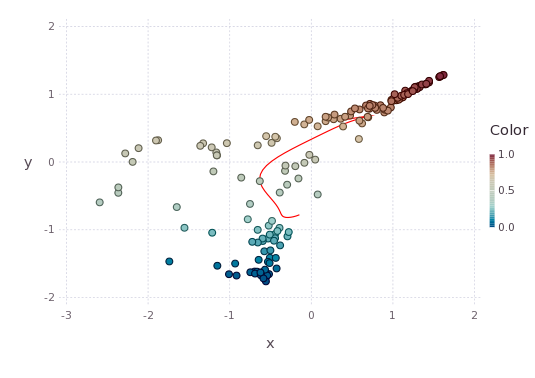

In [136]:
tp = linspace(0, 1, 50)
plot_posterior_mean(mh1, tp, X)

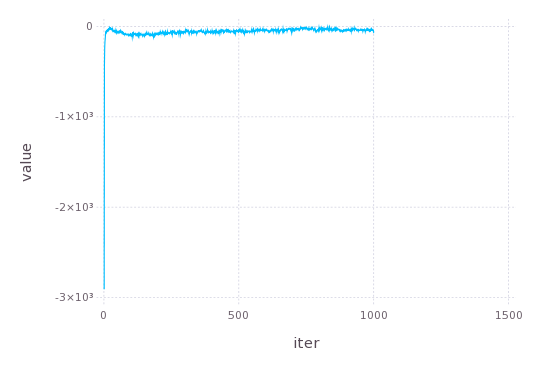

In [127]:
plot_likelihood(mh1)

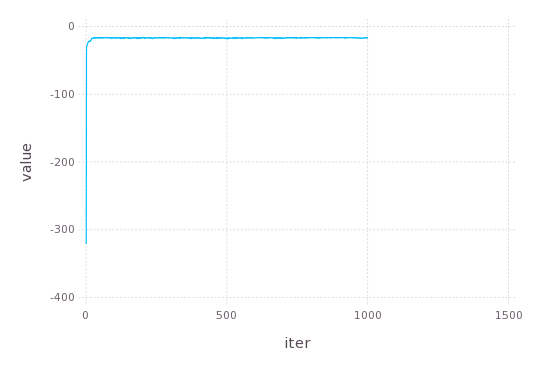

In [128]:
plot_likelihood(mh1, term = "prior_chain")

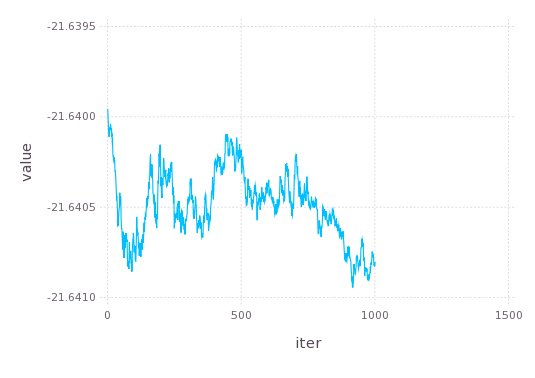

In [129]:
plot_likelihood(mh1, term = "lambda_prior_chain")

In [75]:
mh1["tau_chain"][1001,:,:]

1x155x2 Array{Float64,3}:
[:, :, 1] =
 100.079  99.9854  100.052  100.061  …  99.8624  100.045  99.9286  100.054

[:, :, 2] =
 99.8721  99.8424  100.039  100.172  …  100.061  99.9082  99.8541  100.063

## Using fixed hyperparameters

In [175]:
tau_chain = mh1["tau_chain"];
bp = int(size(tau_chain)[1] / 2)

501

In [202]:
include("../pseudogp_student_fixed.jl");
srand(123)

N, P = size(X)


n_iter = int(1e6)
burn = n_iter / 2

thin = int(n_iter / 1000)

# pseudotime parameters
eps = 1e-6
t =  rand(Uniform(.5 - eps, .5 + eps), N) # t_gt #  
tvar = 6.5e-3

# GP function
s = [30, 30]
tau = fill(0.0, size(X))

for j in 1:P
    for i in 1:N
        tau[i,j] = mean(vec(tau_chain[bp:end,j,j]))
    end
end

# kernel parameters
lambda = [50, 10]

r = 1e-3 # repulsion parameter

return_burn = true # should the burn period be returned in the traces?

gamma = 50000.0

mhf = pseudogp_student_fixed(X, n_iter, burn, thin, tau, t, tvar, lambda, s, r = r, gamma = gamma)

Dict{Any,Any} with 7 entries:
  "burn_acceptance_rate" => 0.023584
  "prior_chain"          => [-321.03415261182835,-37.332765001504725,-33.8895146…
  "r"                    => 0.001
  "likelihood_chain"     => [-8596.921585925682,-803.1271230031114,-320.44098065…
  "params"               => {"n_iter"=>1000000,"burn_thin"=>500,"burn"=>500000.0…
  "tchain"               => [0.5000005368953504 0.5000008810300015 0.50000034791…
  "acceptance_rate"      => 0.023584

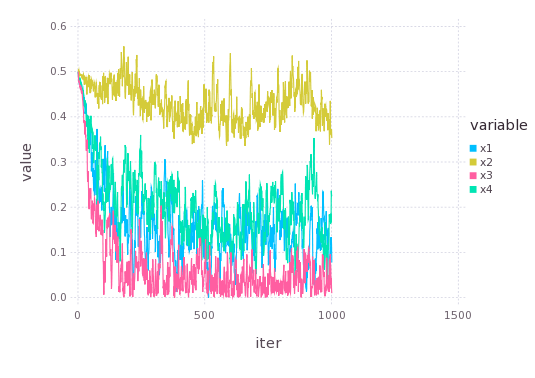

In [199]:
plot_pseudotime_trace(mhf)

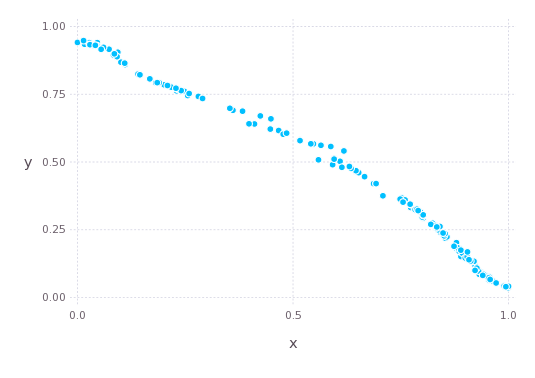

In [200]:
bt = mhf["params"]["burn_thin"]

Gadfly.plot(x = vec(t_gt), y = vec(mean(mhf["tchain"][bt:end,:], 1)))

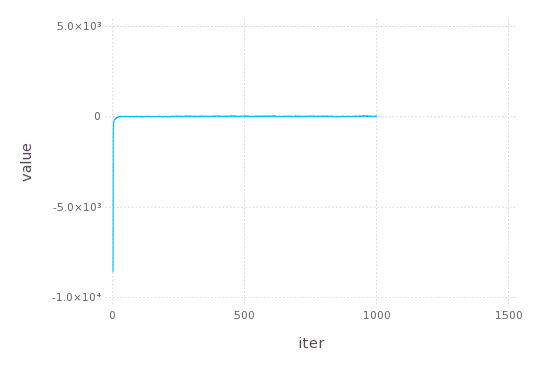

In [201]:
plot_likelihood(mhf)

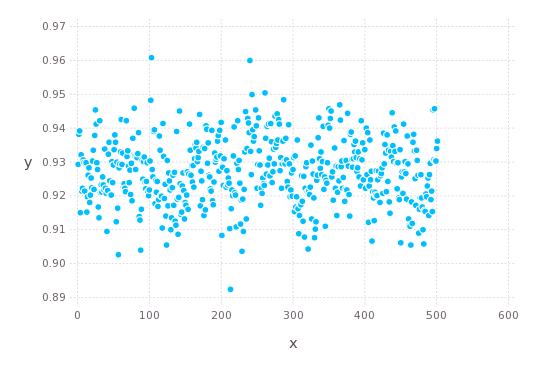

In [27]:
kt = kendall_tau(mh1)

#h5write(trace_file, "kt", kt)
plot(x = 1:length(kt), y = kt)

## Measures of reordering

In [29]:
## average kendall-tau
println(mean(kt)) ## after burn - in

0.8365467640337253
